# Dataset

In [1]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [2]:
data.target_names

['MedHouseVal']

In [3]:
X, Y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class Custom_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X_return = torch.tensor(self.X[idx], dtype = torch.float32)
        Y_return = torch.tensor(self.Y[idx], dtype = torch.float32)
        return X_return, Y_return
        

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size = 0.8, shuffle = True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_val_scale = scaler.transform(X_val)

train_dataset = Custom_Dataset(X_train_scale, Y_train)
test_dataset = Custom_Dataset(X_test_scale, Y_test)
val_dataset = Custom_Dataset(X_val_scale, Y_val)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)


# Deep Learning Model

In [5]:
import torch.nn as nn

In [6]:
class ANN_Model(nn.Module):
    def __init__(self, n_features, n_target):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 50),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(12, n_target)
        )
    def forward(self, x):
        return self.model(x)

# Training

In [7]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
torch.cuda.empty_cache()
def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scaler = torch.cuda.amp.GradScaler()
    lst_loss = []
    mean_loss = 0
    lst_mean_loss = []
    val_lst_loss = []
    val_mean_loss = 0
    val_lst_mean_loss = []
    test_lst_loss = []
    test_mean_loss = 0
    test_lst_mean_loss = []
    for epoch in range(epochs):
        print("Epoch: ", epoch+1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loop.set_postfix(loss_function = loss.item())
        
        model.eval()
        lst_loss = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        
        val_lst_loss = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        
        test_lst_loss = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).reshape(-1,1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        
    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1]        

Epoch:  1


100%|█████████████████████████████████████████████████████████████| 265/265 [00:04<00:00, 54.93it/s, loss_function=3.7]


Epoch:  2


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 142.46it/s, loss_function=2.47]


Epoch:  3


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 142.30it/s, loss_function=0.409]


Epoch:  4


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.33it/s, loss_function=1.04]


Epoch:  5


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 155.00it/s, loss_function=0.24]


Epoch:  6


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 148.80it/s, loss_function=0.556]


Epoch:  7


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 168.77it/s, loss_function=0.859]


Epoch:  8


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 159.43it/s, loss_function=0.346]


Epoch:  9


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 165.44it/s, loss_function=0.637]


Epoch:  10


100%|████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 162.71it/s, loss_function=1.2]


Epoch:  11


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 160.38it/s, loss_function=1.78]


Epoch:  12


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 166.30it/s, loss_function=0.417]


Epoch:  13


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 165.62it/s, loss_function=0.815]


Epoch:  14


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 174.25it/s, loss_function=0.569]


Epoch:  15


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 184.67it/s, loss_function=0.914]


Epoch:  16


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 160.96it/s, loss_function=0.742]


Epoch:  17


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 144.79it/s, loss_function=1.08]


Epoch:  18


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 152.31it/s, loss_function=2.12]


Epoch:  19


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 136.83it/s, loss_function=0.296]


Epoch:  20


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 151.58it/s, loss_function=1.11]


Epoch:  21


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 155.26it/s, loss_function=0.357]


Epoch:  22


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 186.24it/s, loss_function=0.211]


Epoch:  23


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 182.73it/s, loss_function=0.66]


Epoch:  24


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 167.99it/s, loss_function=0.305]


Epoch:  25


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 222.20it/s, loss_function=1.09]


Epoch:  26


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 210.34it/s, loss_function=2.33]


Epoch:  27


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 166.76it/s, loss_function=1.09]


Epoch:  28


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 180.99it/s, loss_function=0.596]


Epoch:  29


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 168.51it/s, loss_function=5.55]


Epoch:  30


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 159.50it/s, loss_function=0.596]


Epoch:  31


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 153.55it/s, loss_function=0.635]


Epoch:  32


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 148.25it/s, loss_function=0.123]


Epoch:  33


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 129.81it/s, loss_function=0.764]


Epoch:  34


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.76it/s, loss_function=1.23]


Epoch:  35


100%|██████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.22it/s, loss_function=1]


Epoch:  36


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 139.58it/s, loss_function=0.316]


Epoch:  37


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.54it/s, loss_function=1.36]


Epoch:  38


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 142.44it/s, loss_function=0.535]


Epoch:  39


100%|████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.89it/s, loss_function=1.1]


Epoch:  40


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.72it/s, loss_function=1.17]


Epoch:  41


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 140.92it/s, loss_function=0.213]


Epoch:  42


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 163.67it/s, loss_function=0.571]


Epoch:  43


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 160.14it/s, loss_function=1.41]


Epoch:  44


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.01it/s, loss_function=0.505]


Epoch:  45


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 141.57it/s, loss_function=0.65]


Epoch:  46


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.97it/s, loss_function=0.957]


Epoch:  47


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 135.28it/s, loss_function=1.58]


Epoch:  48


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 134.01it/s, loss_function=0.539]


Epoch:  49


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 135.98it/s, loss_function=0.769]


Epoch:  50


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 136.23it/s, loss_function=0.387]


Epoch:  51


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.18it/s, loss_function=0.654]


Epoch:  52


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 139.01it/s, loss_function=0.703]


Epoch:  53


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 143.61it/s, loss_function=0.314]


Epoch:  54


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.00it/s, loss_function=0.248]


Epoch:  55


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 141.63it/s, loss_function=0.877]


Epoch:  56


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 121.83it/s, loss_function=0.346]


Epoch:  57


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.80it/s, loss_function=0.053]


Epoch:  58


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 114.54it/s, loss_function=0.992]


Epoch:  59


100%|███████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 121.50it/s, loss_function=2.27]


Epoch:  60


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.16it/s, loss_function=0.847]


Epoch:  61


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 144.25it/s, loss_function=0.221]


Epoch:  62


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 132.88it/s, loss_function=0.715]


Epoch:  63


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.44it/s, loss_function=0.222]


Epoch:  64


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 134.34it/s, loss_function=0.506]


Epoch:  65


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.61it/s, loss_function=0.779]


Epoch:  66


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 135.62it/s, loss_function=0.701]


Epoch:  67


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.78it/s, loss_function=0.323]


Epoch:  68


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.95it/s, loss_function=0.151]


Epoch:  69


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 136.62it/s, loss_function=0.298]


Epoch:  70


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 139.33it/s, loss_function=0.373]


Epoch:  71


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.08it/s, loss_function=0.157]


Epoch:  72


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.91it/s, loss_function=0.507]


Epoch:  73


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 134.12it/s, loss_function=0.433]


Epoch:  74


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.90it/s, loss_function=0.228]


Epoch:  75


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 134.86it/s, loss_function=0.33]


Epoch:  76


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 134.50it/s, loss_function=0.173]


Epoch:  77


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 132.65it/s, loss_function=0.285]


Epoch:  78


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.90it/s, loss_function=0.426]


Epoch:  79


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 129.94it/s, loss_function=0.293]


Epoch:  80


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 141.01it/s, loss_function=1.04]


Epoch:  81


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 143.31it/s, loss_function=0.335]


Epoch:  82


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.16it/s, loss_function=0.318]


Epoch:  83


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 135.82it/s, loss_function=0.401]


Epoch:  84


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 136.52it/s, loss_function=0.564]


Epoch:  85


100%|███████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 131.90it/s, loss_function=0.87]


Epoch:  86


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.00it/s, loss_function=0.273]


Epoch:  87


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 131.92it/s, loss_function=0.782]


Epoch:  88


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 132.09it/s, loss_function=0.214]


Epoch:  89


100%|██████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 128.86it/s, loss_function=0.382]


Epoch:  90


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 140.79it/s, loss_function=0.387]


Epoch:  91


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.50it/s, loss_function=0.197]


Epoch:  92


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 140.63it/s, loss_function=0.369]


Epoch:  93


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.99it/s, loss_function=1.12]


Epoch:  94


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.77it/s, loss_function=0.319]


Epoch:  95


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 139.50it/s, loss_function=0.182]


Epoch:  96


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 140.67it/s, loss_function=0.698]


Epoch:  97


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.21it/s, loss_function=1.32]


Epoch:  98


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 136.92it/s, loss_function=0.358]


Epoch:  99


100%|██████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 138.19it/s, loss_function=0.299]


Epoch:  100


100%|███████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 137.38it/s, loss_function=1.23]


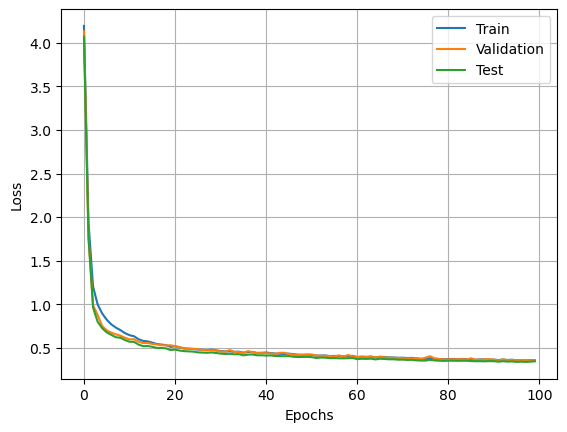

Train Loss:  0.36089820594720123
Validation Loss:  0.3602031093479982
Test Loss 0.34629951130194836


In [8]:
loss_fn = nn.MSELoss()
lr = 1e-4
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ann_model, train_loss, val_loss, test_loss = train(ANN_Model(len(X[0]) , 1).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Make predictions

In [9]:
index = 777
scaler = StandardScaler()
scaler.fit(X_train)
x_index = X[index]
x_input = scaler.transform(np.array([x_index]))
x_input = torch.tensor(x_input, dtype = torch.float32)
x_input = x_input.to(device)
y_index = Y[index]
y_output = torch.tensor(y_index, dtype = torch.float32).reshape(-1,1)
y_output = y_output.to(device)

ann_model.eval()
with torch.no_grad():
    prediction = ann_model(x_input)
    loss = loss_fn(prediction, y_output)

print("Features: ", x_index)
print("Features scale: ", x_input.tolist())
print("Target: ", y_index)
print("Prediction: ", float(prediction))
print("Loss: ", loss.item())

Features:  [   4.4427       31.            5.63322884    1.02507837  796.
    2.49529781   37.65       -122.1       ]
Features scale:  [[0.29564857482910156, 0.1959955245256424, 0.07724723219871521, -0.1415957808494568, -0.5491093397140503, -0.04842826724052429, 0.9472832083702087, -1.2611411809921265]]
Target:  2.045
Prediction:  2.425879716873169
Loss:  0.14506930112838745


# Save model

In [10]:
torch.save(ann_model, "Regression_Model_Checkpoint.pt")